<a href="https://colab.research.google.com/github/japanipsystem/Test/blob/master/20250915_Tiger1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
20250925
Project Tiger
Kosuke Suzuki
'''

'\n20250925\nProject Tiger\n'

In [ ]:
#初期設定
stock = 6963
L = 240
pre = 10
post = 10


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

# Google Drive を /content/drive にマウント
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# tiger フォルダのパスを指定
path = '/content/drive/MyDrive/tiger/'


In [ ]:
# 例: CSVファイルを読み込む
import pandas as pd
df = pd.read_csv(path + '6963.T.csv')
print(df.head())

       Date  Open    High     Low   Close   Volume  Adj Close
0  19890125  3460  3460.0  3450.0  3450.0  46000.0     507.05
1  19890126  3400  3400.0  3360.0  3360.0   4000.0     493.83
2  19890127  3400  3450.0  3400.0  3440.0  15000.0     505.59
3  19890128  3500  3500.0  3500.0  3500.0   1000.0     514.40
4  19890130  3550  3550.0  3500.0  3500.0  22000.0     514.40


In [ ]:
# read Event file
df_event_file = pd.read_excel(path + 'Events.xlsx')
print(df_event_file.head())

# Event == 'Addition'
df_add_events = df_event_file.loc[
    df_event_file['Event'] == 'Addition',
    ['Announcement date', 'Implementation date', 'コード', 'Event']
]

print(df_add_events.head())

# 1. Date -> datetime
df_add_events['Announcement date'] = pd.to_datetime(df_add_events['Announcement date'])
df_add_events['Implementation date'] = pd.to_datetime(df_add_events['Implementation date'])

print(df_add_events.head())


   Record         Document Announcement date Implementation date  定期入れ替え  \
0       1  20250620J_1.pdf        2025-06-20          2025-07-01       1   
1       2  20250620J_1.pdf        2025-06-20          2025-07-01       1   
2       3  20250305J_1.pdf        2025-03-05          2025-04-01       1   
3       4  20250305J_1.pdf        2025-03-05          2025-04-01       1   
4       5  20240904J_1.pdf        2024-09-04          2024-10-01       1   

   株価換算係数      コード      Company     Event  \
0        1  6963.0          ローム  Addition   
1      NaN  9613.0   ＮＴＴデータグループ  Deletion   
2      0.5  6532.0  ベ イ カ レ ン ト  Addition   
3      NaN  9301.0         三菱倉庫  Deletion   
4        1  4307.0      野村総合研究所  Addition   

                                              Reason  
0                                                NaN  
1  TO B ( 株 式 公 開 買 い 付 け ) の 結 果 、 将 来 の 上 場 廃 止...  
2                                                NaN  
3                                                NaN

In [ ]:
df_N225=pd.read_csv(path +'NIKKEI225.csv')
print(df_N225.head())

  observation_date  NIKKEI225
0       1949-05-16     176.21
1       1949-05-17     174.80
2       1949-05-18     172.53
3       1949-05-19     171.34
4       1949-05-20     169.20


In [ ]:
# Calculate log return
df_N225['lmRt'] = np.log(df_N225['NIKKEI225'] / df_N225['NIKKEI225'].shift(1))

df_N225['observation_date'] = pd.to_datetime(df_N225['observation_date'])
print(df_N225.head())

  observation_date  NIKKEI225      lmRt
0       1949-05-16     176.21       NaN
1       1949-05-17     174.80 -0.008034
2       1949-05-18     172.53 -0.013071
3       1949-05-19     171.34 -0.006921
4       1949-05-20     169.20 -0.012568


In [ ]:
# Calculate Market Return

def calReturn(stock):
  stock = path + str(stock) + '.T.csv'
  df_Stock = pd.read_csv(stock)
  df_Stock['lmRt'] = np.log(df_Stock['Close'] / df_Stock['Close'].shift(1))
  df_Stock['Date'] = pd.to_datetime(df_Stock['Date'].astype(str), format='%Y%m%d')
  return df_Stock

In [ ]:
def eventday(code_num):
  event_day = df_add_events.loc[df_add_events["コード"] == code_num, "Announcement date"].iloc[0]
  return event_day

In [ ]:
def setDate(stock, L=240, pre=10, post=10):
    # 価格→リターン作成
    df_Stock = calReturn(stock)                   # 必須: Date(=datetime or YYYYMMDD), lmRt
    event_day = eventday(stock)                   # 必須: pd.Timestamp を返す想定
    event_day = pd.to_datetime(event_day)

    # 期間はカレンダー日ベースでフィルタ
    start_date = event_day - pd.Timedelta(days=L+10)  # [-L-10, +10]
    end_date   = event_day + pd.Timedelta(days=10)

    # マーケット側の切り出し
    sub_N225 = df_N225[
        (df_N225['observation_date'] >= start_date) &
        (df_N225['observation_date'] <= end_date)
    ].copy()

    # ストック側の切り出し
    sub_Stock = df_Stock[
        (df_Stock['Date'] >= start_date) &
        (df_Stock['Date'] <= end_date)
    ].copy()

    # マージ（同日で結合）
    dfM = pd.merge(
        sub_Stock[['Date','lmRt']].rename(columns={'lmRt':'r_stock'}),
        sub_N225[['observation_date','lmRt']].rename(columns={'lmRt':'r_mkt', 'observation_date':'Date'}),
        on='Date', how='inner'
    ).dropna()

    # 0リターンを後ろにして同日1行に（非ゼロ優先で残す）
    dfM['is_zero'] = (dfM['r_stock'].abs() < 1e-15)
    dfM = (dfM.sort_values(['Date','is_zero'])
              .drop_duplicates(subset='Date', keep='first')
              .drop(columns='is_zero')
              .sort_values('Date')
              .reset_index(drop=True))

    # ===== ここから追加：取引日ベースの τ を付与 =====
    dates = dfM['Date'].sort_values().unique()
    rank = pd.Series(range(len(dates)), index=dates)  # Date → 0..N-1

    anchor = rank.get(event_day)
    if anchor is None:
        # イベント日が取引日でない場合は「翌取引日」。無ければ直前。
        later = rank[rank.index > event_day]
        anchor = later.min() if not later.empty else rank.max()

    dfM['tau'] = dfM['Date'].map(rank) - int(anchor)

    # 返り値
    return dfM, event_day


In [ ]:
def calOLS(dfM, L=240):
    """
    dfM: setDate()でtauが付与されたDataFrame（列: Date, r_stock, r_mkt, tau）
    L  : 推定ウインドウの過去長（[-L, -10]）
    """
    est = dfM[(dfM['tau'] >= -L) & (dfM['tau'] <= -10)].copy()
    # サンプルチェック
    if len(est) < 20 or est['r_mkt'].var() == 0:
        return np.nan, np.nan

    rm = est['r_mkt'].values
    rs = est['r_stock'].values

    beta  = np.sum((rm - rm.mean())*(rs - rs.mean())) / np.sum((rm - rm.mean())**2)
    alpha = rs.mean() - beta*rm.mean()
    return alpha, beta


In [ ]:
# t検定
def compute_event_ar_from_dfM(dfM, alpha, beta, L=240, pre=10, post=10, code_num=None):
    """
    前提: dfM には ['Date','r_stock','r_mkt','tau'] があり、tau は取引日ベース。
    1) 推定ウインドウ[-L, -10]から sigma_hat_AR を推定
    2) イベントウインドウ[-pre, +post]で AR/CAR
    3) SE(CAR_tau), t_CAR を付与
    戻り値: ev（各tauのAR/CAR/tを含む）, sigma_hat_AR
    """
    # ---- 推定ウインドウ [-L, -10] で残差分散（標準偏差）を推定 ----
    est = dfM[(dfM['tau'] >= -L) & (dfM['tau'] <= -10)].copy()
    if len(est) >= 3 and est['r_mkt'].var() > 0:
        est['resid'] = est['r_stock'] - (alpha + beta * est['r_mkt'])
        sigma_hat_AR = est['resid'].std(ddof=1)   # 標本標準偏差
    else:
        sigma_hat_AR = np.nan  # サンプル不足

    # ---- イベントウインドウ [-pre, +post] ----
    ev = (dfM[(dfM['tau'] >= -pre) & (dfM['tau'] <= post)]
            .copy()
            .sort_values('tau')
            .reset_index(drop=True))

    # 期待収益・AR・CAR
    ev['expected'] = alpha + beta * ev['r_mkt']
    ev['AR'] = ev['r_stock'] - ev['expected']
    ev['CAR'] = ev['AR'].cumsum()

    # ---- SE(CAR_tau) と t統計量 ----
    # 欠損tauがあってもズレないように、単純な累積カウントで観測数を作る
    ev['n_tau'] = np.arange(1, len(ev) + 1, dtype=int)

    if np.isnan(sigma_hat_AR) or sigma_hat_AR == 0:
        ev['SE_CAR'] = np.nan
        ev['t_CAR'] = np.nan
    else:
        ev['SE_CAR'] = np.sqrt(ev['n_tau']) * sigma_hat_AR
        ev['t_CAR'] = ev['CAR'] / ev['SE_CAR']

    if code_num is not None:
        ev['Code'] = code_num

    cols = ['Date','tau','r_stock','r_mkt','expected','AR','CAR','SE_CAR','t_CAR','n_tau']
    if 'Code' in ev.columns:
        cols.append('Code')

    return ev[cols], sigma_hat_AR


In [ ]:
# 1) マージ＆τ付与
dfM_i, event_day_i = setDate(stock=6963, L=240, pre=10, post=10)

# 2) 推定ウインドウで α・β を推定
alpha_i, beta_i = calOLS(dfM_i, L=240)

# 3) イベントウィンドで AR/CAR を算出
ev_i, sigma_hat_AR_i = compute_event_ar_from_dfM(
    dfM=dfM_i, alpha=alpha_i, beta=beta_i,
    L=240, pre=10, post=10, code_num=6963
)
print(ev_i.head(21))
print("sigma_hat_AR (est window):", sigma_hat_AR_i)

         Date  tau   r_stock     r_mkt  expected        AR       CAR  \
0  2025-06-06  -10 -0.009203  0.004970  0.005247 -0.014450 -0.014450   
1  2025-06-09   -9 -0.005562  0.009151  0.009560 -0.015123 -0.029572   
2  2025-06-10   -8  0.023581  0.003223  0.003444  0.020137 -0.009436   
3  2025-06-11   -7  0.037426  0.005472  0.005765  0.031661  0.022225   
4  2025-06-12   -6 -0.003505 -0.006478 -0.006563  0.003059  0.025284   
5  2025-06-13   -5 -0.031201 -0.008916 -0.009078 -0.022123  0.003161   
6  2025-06-16   -4 -0.003932  0.012531  0.013047 -0.016979 -0.013818   
7  2025-06-17   -3  0.001211  0.005866  0.006172 -0.004960 -0.018778   
8  2025-06-18   -2  0.005433  0.009000  0.009405 -0.003972 -0.022750   
9  2025-06-19   -1  0.011374 -0.010257 -0.010462  0.021836 -0.000914   
10 2025-06-20    0  0.003862 -0.002214 -0.002164  0.006026  0.005111   
11 2025-06-23    1  0.051145 -0.001280 -0.001201  0.052346  0.057457   
12 2025-06-24    2  0.006738  0.011316  0.011793 -0.005056  0.05

In [ ]:
# CAARを求める。
# ハイパラ（必要なら調整）
L, pre, post = 240, 10, 10

# 1) イベント候補を準備（Additionのみ、必要列のみ）
df_use = (df_add_events
          .loc[df_add_events['Event']=='Addition', ['Announcement date','コード']]
          .dropna())
df_use['Announcement date'] = pd.to_datetime(df_use['Announcement date'])
df_use['コード'] = df_use['コード'].astype(int)

all_evs = []    # 各銘柄×τのAR/CAR等を積む
errors  = []    # スキップや失敗の記録

for _, row in df_use.iterrows():
    stock = int(row['コード'])
    try:
        # 2) マージ & τ 付与
        dfM_i, event_day_i = setDate(stock=stock, L=L, pre=pre, post=post)

        # 3) 推定ウインドウで α・β を推定
        alpha_i, beta_i = calOLS(dfM_i, L=L)

        # 4) イベントウインドウで AR/CAR と（関数内で）t関連を算出
        #    ※ compute_event_ar_from_dfM は、前回お渡しした t付き版に差し替えてある想定
        ev_i, sigma_hat_AR_i = compute_event_ar_from_dfM(
            dfM=dfM_i, alpha=alpha_i, beta=beta_i,
            L=L, pre=pre, post=post, code_num=stock
        )

        # メタ情報
        ev_i['Announcement date'] = event_day_i
        ev_i['alpha_used'] = alpha_i
        ev_i['beta_used']  = beta_i
        ev_i['sigma_hat_AR'] = sigma_hat_AR_i

        all_evs.append(ev_i)

    except Exception as e:
        errors.append((stock, str(e)))

# 5) 連結（全イベントのAR/CARが縦積み）
df_events_all = pd.concat(all_evs, ignore_index=True) if all_evs else pd.DataFrame()

# 6) AAR/CAAR を作成
#    AAR: τごとの AR のクロスセクション平均
AAR = (df_events_all.groupby('tau', as_index=False)['AR']
       .mean()
       .rename(columns={'AR':'AAR'})
       .sort_values('tau'))
#    CAAR: AAR を τ順に累積
AAR['CAAR'] = AAR['AAR'].cumsum()

# 参考：CAR を平均して CAAR を作る等価な確認（数値は一致するはず）
CAAR_check = (df_events_all.groupby('tau', as_index=False)['CAR']
              .mean()
              .rename(columns={'CAR':'CAAR_alt'})
              .sort_values('tau'))

print("AAR / CAAR (head):")
print(AAR.head(12))
print("\nCross-check (mean CAR as CAAR_alt):")
print(CAAR_check.head(12))

if errors:
    print("\nSkipped / errors:", errors)


AAR / CAAR (head):
    tau       AAR      CAAR
0   -10 -0.002607 -0.002607
1    -9 -0.001221 -0.003828
2    -8  0.000853 -0.002975
3    -7 -0.001255 -0.004230
4    -6  0.001811 -0.002419
5    -5  0.001078 -0.001341
6    -4  0.002356  0.001014
7    -3 -0.003040 -0.002026
8    -2 -0.000788 -0.002814
9    -1 -0.000995 -0.003809
10    0  0.013442  0.009634
11    1  0.040030  0.049664

Cross-check (mean CAR as CAAR_alt):
    tau  CAAR_alt
0   -10 -0.002607
1    -9 -0.003828
2    -8 -0.002975
3    -7 -0.004230
4    -6 -0.002419
5    -5 -0.001341
6    -4  0.001014
7    -3 -0.002026
8    -2 -0.002814
9    -1 -0.003809
10    0  0.009634
11    1  0.049664

Skipped / errors: [(5831, 'cannot convert float NaN to integer'), (9147, 'cannot convert float NaN to integer'), (8028, "[Errno 2] No such file or directory: '/content/drive/MyDrive/tiger/8028.T.csv'"), (7186, 'cannot convert float NaN to integer'), (1333, 'cannot convert float NaN to integer'), (3289, 'cannot convert float NaN to integer'), (

In [ ]:
# クロスセクション平均の CAAR とその t 統計量

def compute_CAAR_and_t(df_events_all, pre=10, post=10):
    """
    入力: df_events_all … 縦積み（stacked）のイベント結果
         必須列: ['Code','Announcement date','tau','AR']
    出力: DataFrame[ tau, AAR, CAAR, N_eff, SE_CAAR, t_CAAR ]
    """
    # 1) ピボット（行=イベント, 列=τ, 値=AR）
    df_panel = (df_events_all[['Code','Announcement date','tau','AR']]
                .drop_duplicates(subset=['Code','Announcement date','tau']))
    df_panel['Announcement date'] = pd.to_datetime(df_panel['Announcement date'])
    # イベントID（同コードでも別アナウンス日は別イベント）
    df_panel['event_id'] = (df_panel['Code'].astype(str) + '_' +
                            df_panel['Announcement date'].dt.strftime('%Y%m%d'))
    # pivot: 行=event_id, 列=tau, 値=AR
    AR_pivot = df_panel.pivot_table(index='event_id', columns='tau', values='AR', aggfunc='mean')
    AR_pivot = AR_pivot.reindex(columns=sorted(AR_pivot.columns))  # τの昇順

    taus = [t for t in AR_pivot.columns if (t >= -pre and t <= post)]
    AR_pivot = AR_pivot[taus]

    # 2) AAR と CAAR（参考: 全イベントの単純平均。t計算は下で subset毎に再計算）
    AAR_all = AR_pivot.mean(axis=0, skipna=True)
    CAAR_all = AAR_all.cumsum()

    # 3) τ*ごとに、完全観測のイベントのみで CAAR と分散を評価
    rows = []
    for k, tau_star in enumerate(taus):
        cols = taus[:k+1]  # -pre から tau* まで
        sub = AR_pivot[cols].dropna(axis=0, how='any')  # 完全観測のみ
        N_eff = len(sub)
        if N_eff < 2:
            rows.append({'tau': tau_star,
                         'AAR': AAR_all.loc[tau_star],
                         'CAAR': CAAR_all.loc[tau_star],
                         'N_eff': N_eff, 'SE_CAAR': np.nan, 't_CAAR': np.nan})
            continue

        # AAR（subsetで再計算）→ CAAR（その和）
        AAR_sub = sub.mean(axis=0)
        CAAR_tau = AAR_sub.sum()

        # クロスセクション共分散行列（イベント方向の共分散）
        S = sub.cov(ddof=1)  # 形は len(cols)×len(cols)
        one = np.ones(len(cols))
        var_CAAR = (one @ S.values @ one) / N_eff   # Var(和(平均AR)) = (1/N)*1'S1
        SE_CAAR  = np.sqrt(var_CAAR)
        t_CAAR   = CAAR_tau / SE_CAAR if SE_CAAR > 0 else np.nan

        rows.append({'tau': tau_star,
                     'AAR': AAR_sub.iloc[-1],    # 直近τの平均AR（参考）
                     'CAAR': CAAR_tau,
                     'N_eff': N_eff,
                     'SE_CAAR': SE_CAAR,
                     't_CAAR': t_CAAR})

    out = pd.DataFrame(rows).sort_values('tau').reset_index(drop=True)
    return out, pd.DataFrame({'tau': taus, 'AAR': AAR_all.values, 'CAAR': CAAR_all.values})




In [ ]:
# 使用例
CAAR_t, AAR_all = compute_CAAR_and_t(df_events_all, pre=10, post=10)
print(CAAR_t.head(21))


    tau       AAR      CAAR  N_eff   SE_CAAR    t_CAAR
0   -10 -0.002591 -0.002591     95  0.002517 -1.029603
1    -9 -0.001252 -0.003843     95  0.003497 -1.098902
2    -8  0.000868 -0.002974     95  0.003932 -0.756545
3    -7 -0.001411 -0.004385     95  0.004560 -0.961693
4    -6  0.001969 -0.002417     95  0.005046 -0.478964
5    -5  0.001157 -0.001260     95  0.005778 -0.218001
6    -4  0.002373  0.001114     95  0.006010  0.185289
7    -3 -0.003059 -0.001945     95  0.006805 -0.285881
8    -2 -0.000760 -0.002705     95  0.007551 -0.358219
9    -1 -0.001048 -0.003753     95  0.007717 -0.486286
10    0  0.013647  0.009894     95  0.008564  1.155380
11    1  0.040402  0.050296     95  0.009011  5.581616
12    2  0.004323  0.054619     95  0.008978  6.083797
13    3  0.002671  0.057290     95  0.009885  5.795876
14    4  0.020498  0.077788     95  0.013535  5.747022
15    5 -0.011428  0.065773     92  0.011978  5.491195
16    6  0.001018  0.068417     85  0.012824  5.335301
17    7  0

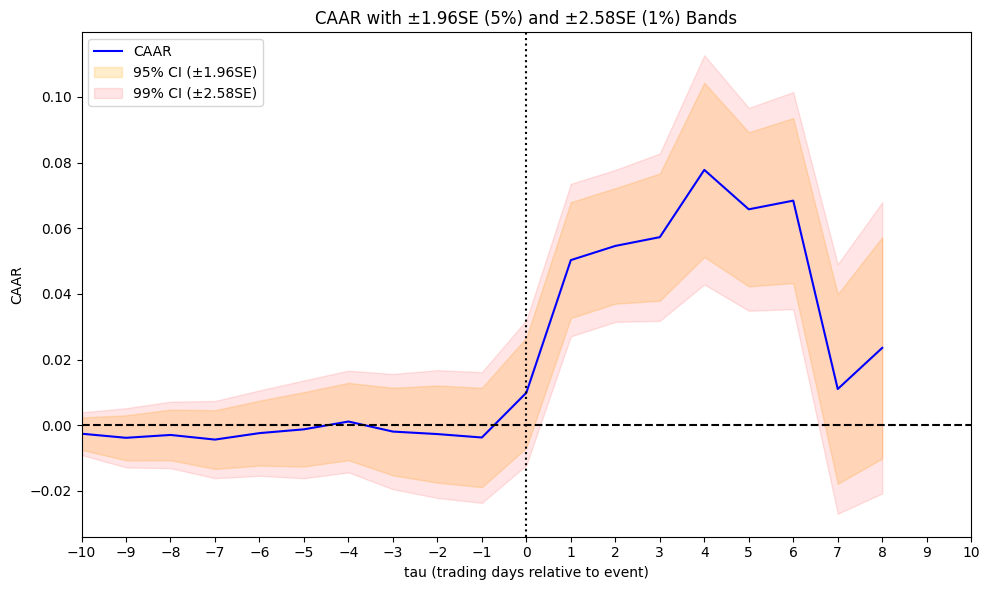

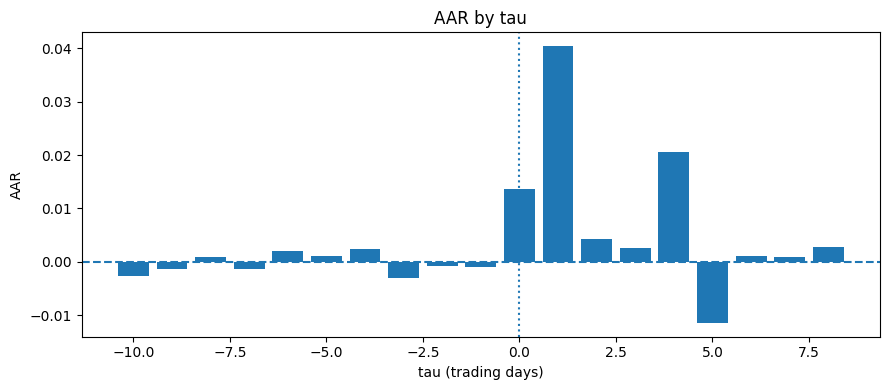

In [ ]:
# --- 図1: CAAR + with ±1.96SE (5%) and ±2.58SE (1%) Bands ---
# CAAR_t をソート
CAAR_t = CAAR_t.sort_values('tau').reset_index(drop=True)
taus = CAAR_t['tau'].to_numpy()
caar = CAAR_t['CAAR'].to_numpy()
se   = CAAR_t['SE_CAAR'].to_numpy()

plt.figure(figsize=(10,6))
plt.plot(taus, caar, label='CAAR', color='blue')

# ±1.96SE (5%) と ±2.58SE (1%) のバンド
plt.fill_between(taus, caar - 1.96*se, caar + 1.96*se,
                 alpha=0.2, color='orange', label='95% CI (±1.96SE)')
plt.fill_between(taus, caar - 2.58*se, caar + 2.58*se,
                 alpha=0.1, color='red', label='99% CI (±2.58SE)')

# 基準線
plt.axhline(0, linestyle='--', color='black')
plt.axvline(0, linestyle=':', color='black')

# x軸を -10 から 10 の整数に固定
plt.xticks(np.arange(-10, 11, 1))
plt.xlim(-10, 10)

plt.title('CAAR with ±1.96SE (5%) and ±2.58SE (1%) Bands')
plt.xlabel('tau (trading days relative to event)')
plt.ylabel('CAAR')
plt.legend()
plt.tight_layout()
plt.show()

# --- 図2: AAR（棒グラフ）---
if 'AAR_all' in globals() and isinstance(AAR_all, pd.DataFrame):
    AAR_plot = AAR_all.sort_values('tau')
    plt.figure(figsize=(9,4))
    plt.bar(AAR_plot['tau'].to_numpy(), AAR_plot['AAR'].to_numpy(), width=0.8, align='center')
    plt.axhline(0, linestyle='--')
    plt.axvline(0, linestyle=':')
    plt.title('AAR by tau')
    plt.xlabel('tau (trading days)')
    plt.ylabel('AAR')
    plt.tight_layout()
    plt.show()
else:
    print("AAR_all が見つからないため、AAR図はスキップしました。")
